In [1]:
import torch.nn as nn
from torchvision import torch,datasets,transforms,models
import matplotlib.pyplot as plt
import numpy as np
import imutils
from PIL import Image as Image_PIL
import cv2
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imutils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
from torch.autograd import Variable

In [2]:
def transform(): ################transform the data into gray image then random flip then to tensor and normalize
    transform_train = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ])
    return transform_train

class SplitDataFromTrainAndTest(Dataset):         ######################Using by torch dataset to split#############
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

def Find_Edge_Plate(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # Noise reduction
    edged = cv2.Canny(bfilter, 30, 100)  # Edge detection
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [location], 0, 255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)
    (x, y) = np.where(mask == 255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    gray = gray[x1:x2 + 1, y1:y2 + 1]
    Image = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)
    return Image


# Match outlines to license plate or character templates
def find_contours(dimensions, img):
    # Find all contours in an image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve latent dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check up to 5 or 15 outlines of license plates or characters, respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs:
        # Detect contour in binary image and return coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        #Check the size of the outline to filter out characters by the size of the outline
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(
                intX)  # Stores the x-coordinate of the glyph for later use in indexing the outline

            char_copy = np.zeros((44, 24))
            # Extract each character using the coordinates of the enclosing rectangle
            char = img[intY:intY + intHeight, intX:intX + intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX, intY), (intWidth + intX, intY + intHeight), (50, 21, 200), 2)
            plt.imshow(ii, cmap='gray')

            # Make results in categorical format: invert colors
            char = cv2.subtract(255, char)

            # Resize image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)  # A list of binary images that store characters

    # Returns characters in ascending order relative to the x-coordinate (leftmost character first)

    plt.show()
    # Arbitrary function that stores a sorted list of characters
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # Store character images based on the index of the character image
    img_res = np.array(img_res_copy)

    return img_res


# Find characters in generated images
def segment_characters(image):
    # Preprocessing cropped license plate images
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)  # Convert BGR format to grayscale image
    # Divide the entire image into binary images that are either black or white
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Corroded image The higher the degree of blurring (corrosion), the higher the positive correlation
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    # Do the expansion operation
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # make the border white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimate character outline size for cropped license plates
    dimensions = [LP_WIDTH / 6,
                  LP_WIDTH / 2,
                  LP_HEIGHT / 10,
                  2 * LP_HEIGHT / 3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get outline inside cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [3]:
channel_in = 1
channel_out = 6
kernel_size = 5
stride = 2
out_class = 36  # 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
kernel_size_pooling = 2
class LeNet(nn.Module): # LeNet
    def __init__(self):
        super(LeNet, self).__init__()
        '''
        Define the first Convolutional Layer
        '''
        self.conv1 = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, kernel_size), # in_channels, out_channels, kernel_size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size_pooling, stride), # kernel_size, stride
        )
        '''
           Define the second Convolutional Layer
        '''
        self.conv2 = nn.Sequential(
            nn.Conv2d(channel_out, 16, kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(stride, stride)
        )
        '''
        Define Fully Connect Layer 1
        '''
        self.fc1 = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.ReLU()
        )
        '''
        Define Fully Connect Layer 2
        '''
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        '''
        Define Output Layer
        '''
        self.out = nn.Linear(84, out_class)

    def forward(self, img):
        feature1 = self.conv1(img)
        feature2 = self.conv2(feature1)
        fc1 = self.fc1(feature2.view(img.shape[0], -1))
        fc2 = self.fc2(fc1)
        output = self.out(fc2)
        return output

def test_network(net,testloader,device):      ############Test Data For Once##########
    net.eval()
    total_images = 0
    total_correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    model_accuracy = total_correct / total_images * 100
    print('Accuracy on {0} testing Dataset: {1:.2f}%'.format(total_images, model_accuracy))
    net.train()

In [4]:
torch.manual_seed(11)
'''
Hypermeters
'''
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
dataset = "./Character_36_Data"
train_val_split = 0.8 # we split data into 80% train data and 20% test data
batch_size = 64 # 128 or 256
epochs = 200
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
'''
Data_Loader
'''
data = torchvision.datasets.ImageFolder(root=dataset)
train_len = int((train_val_split)*len(data))
valid_len = len(data) - train_len
train_subset, valid_subset = random_split(data, [train_len, valid_len])
trainset = SplitDataFromTrainAndTest(train_subset, transform=transform())
validset = SplitDataFromTrainAndTest(valid_subset, transform=transform())

trainloader = torch.utils.data.DataLoader(trainset,  batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

'''
Train
'''
for epoch in range(1, epochs + 1):
    total_loss = 0
    total_images = 0
    total_correct = 0
    for batch in trainloader:  # Load batch
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        output = outputs.argmax(dim=1)
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        model_accuracy = total_correct / total_images * 100

    print('Epoch {0} correct Sample: {1} loss Computing: {2:.2f} accuracy for Training: {3:.2f}'.format(
        epoch, total_correct, total_loss, model_accuracy))
    test_network(model, validloader,device)

torch.save(model, 'model.pkl')

Epoch 1 correct Sample: 43 loss Computing: 49.74 accuracy for Training: 4.98
Accuracy on 216 testing Dataset: 8.80%
Epoch 2 correct Sample: 104 loss Computing: 45.67 accuracy for Training: 12.04
Accuracy on 216 testing Dataset: 18.52%
Epoch 3 correct Sample: 256 loss Computing: 34.17 accuracy for Training: 29.63
Accuracy on 216 testing Dataset: 37.04%
Epoch 4 correct Sample: 464 loss Computing: 20.94 accuracy for Training: 53.70
Accuracy on 216 testing Dataset: 56.02%
Epoch 5 correct Sample: 583 loss Computing: 14.29 accuracy for Training: 67.48
Accuracy on 216 testing Dataset: 67.13%
Epoch 6 correct Sample: 629 loss Computing: 11.63 accuracy for Training: 72.80
Accuracy on 216 testing Dataset: 72.69%
Epoch 7 correct Sample: 682 loss Computing: 8.64 accuracy for Training: 78.94
Accuracy on 216 testing Dataset: 81.94%
Epoch 8 correct Sample: 712 loss Computing: 7.07 accuracy for Training: 82.41
Accuracy on 216 testing Dataset: 80.09%
Epoch 9 correct Sample: 707 loss Computing: 7.16 accu

Epoch 70 correct Sample: 853 loss Computing: 0.36 accuracy for Training: 98.73
Accuracy on 216 testing Dataset: 99.54%
Epoch 71 correct Sample: 852 loss Computing: 0.48 accuracy for Training: 98.61
Accuracy on 216 testing Dataset: 98.15%
Epoch 72 correct Sample: 854 loss Computing: 0.49 accuracy for Training: 98.84
Accuracy on 216 testing Dataset: 97.69%
Epoch 73 correct Sample: 847 loss Computing: 0.51 accuracy for Training: 98.03
Accuracy on 216 testing Dataset: 99.07%
Epoch 74 correct Sample: 855 loss Computing: 0.37 accuracy for Training: 98.96
Accuracy on 216 testing Dataset: 99.07%
Epoch 75 correct Sample: 857 loss Computing: 0.27 accuracy for Training: 99.19
Accuracy on 216 testing Dataset: 98.61%
Epoch 76 correct Sample: 858 loss Computing: 0.30 accuracy for Training: 99.31
Accuracy on 216 testing Dataset: 98.61%
Epoch 77 correct Sample: 857 loss Computing: 0.23 accuracy for Training: 99.19
Accuracy on 216 testing Dataset: 98.15%
Epoch 78 correct Sample: 849 loss Computing: 0.5

Epoch 139 correct Sample: 858 loss Computing: 0.19 accuracy for Training: 99.31
Accuracy on 216 testing Dataset: 98.15%
Epoch 140 correct Sample: 853 loss Computing: 0.35 accuracy for Training: 98.73
Accuracy on 216 testing Dataset: 99.07%
Epoch 141 correct Sample: 857 loss Computing: 0.22 accuracy for Training: 99.19
Accuracy on 216 testing Dataset: 99.54%
Epoch 142 correct Sample: 861 loss Computing: 0.20 accuracy for Training: 99.65
Accuracy on 216 testing Dataset: 100.00%
Epoch 143 correct Sample: 860 loss Computing: 0.17 accuracy for Training: 99.54
Accuracy on 216 testing Dataset: 99.54%
Epoch 144 correct Sample: 860 loss Computing: 0.15 accuracy for Training: 99.54
Accuracy on 216 testing Dataset: 99.07%
Epoch 145 correct Sample: 861 loss Computing: 0.14 accuracy for Training: 99.65
Accuracy on 216 testing Dataset: 98.61%
Epoch 146 correct Sample: 859 loss Computing: 0.24 accuracy for Training: 99.42
Accuracy on 216 testing Dataset: 100.00%
Epoch 147 correct Sample: 858 loss Com

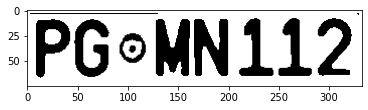

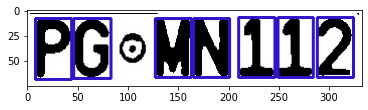

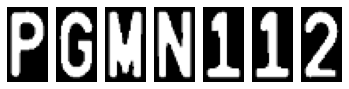

PGMN112


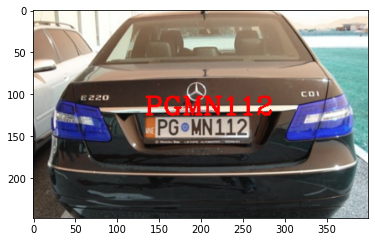

In [5]:
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
output = []

# parser = argparse.ArgumentParser()
# parser.add_argument('--target',type=str,default='images/Cars1.png',help='input, star16 or ch34')
# args = parser.parse_args()



"""
Select the Image your want detect
"""
img = cv2.imread('images/Cars1.png')

"""
Preprocess the image to obtain the effective image of character
"""
Image = Find_Edge_Plate(img)
char = segment_characters(Image)

"""
Load well trained CNN Model
"""
model = LeNet()
net = torch.load('model.pkl')
net.eval()


"""
Based on the zoned image to detect which char belongs to 
"""

for i in range(len(char)):
    plt.subplot(1, len(char), i + 1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

    im = Image_PIL.fromarray(char[i])
    im = im.resize((28, 28))
    img_ = transforms.ToTensor()(im)
    img_ = transforms.Normalize((0.1307,), (0.3081,))(img_)
    img_ = img_.unsqueeze(0)
    with torch.no_grad():
        outputs = net(img_)
        _, predicted = torch.max(outputs.data, 1)
        output.append(characters[predicted.item()])

plt.show()
plate_number = ''.join(output)
print(plate_number)

"""
Draw it on the original Image
"""
y, x, z = img.shape[0:3]
plate_img = cv2.putText(img, plate_number,(x//3, y//2), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)
plt.imshow(plate_img)
plt.show()